# Preparation *section*

## google drive mount

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## unzip tarfile

In [2]:
import os, tarfile

dst_path='/gdrive/My Drive/PROJECT/Recommender/'
dst='/content/Recommender/'
dst_file=dst_path+'lastfm-dataset-360K.tar.gz'

if not os.path.exists(dst):
    os.makedirs(dst)

with tarfile.open(dst_file,mode='r') as file:
    file.extractall(dst)

## Recommand System

> 협업 필터링 : 다수의 사용자가 아이템을 구매한 이력 정보만으로 사용자간 유사성 및 아이템간 유사성을 파악 </br>
단점</br>
* 시스템이 충분한 정보를 모으지 못한 사용자나 아이템에 대한 추론을 할 수 없는 상태인 콜드 스타트(Cold Start) 상황 
* 계산량이 너무 많아 추천의 효율이 떨어지는 상황
* 롱테일의 꼬리 부분, 즉 사용자의 관심이 저조한 항목의 정보가 부족하여 추천에서 배제되는 상황

> 콘텐츠 기반 필터링 : 아이템의 고유의 정보를 바탕으로 아이템간 유사성을 파악

# Dataset

In [3]:
import pandas as pd
import os

data_path = '/content/Recommender/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv'

fname = data_path
col_names = ['user_id', 'artist_MBID', 'artist', 'play']   # 임의로 지정한 컬럼명
data = pd.read_csv(fname, sep='\t', names= col_names)      # sep='\t'로 주어야 tsv를 열 수 있습니다.  
print(data.shape)
data.head(10)


(17535655, 4)


,user_id,artist_MBID,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,3bd73256-3905-4f3a-97e2-8b341527f805,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,f2fb0ff0-5679-42ec-a55c-15109ce6e320,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,b3ae82c2-e60b-4551-a76d-6620f1b456aa,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,3d6bbeb7-f90e-4d10-b440-e153c0d10b53,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,8bfac288-ccc5-448d-9573-c33ea2aa5c30,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,6531c8b1-76ea-4141-b270-eb1ac5b41375,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,21f3573f-10cf-44b3-aeaa-26cccd8448b5,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,c5db90c4-580d-4f33-b364-fbaa5a3a58b5,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,0639533a-0402-40ba-b6e0-18b067198b73,lunachicks,403


In [4]:
# 사용하는 컬럼만 남겨줍니다.
using_cols = ['user_id', 'artist', 'play']
data = data[using_cols]
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die Ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [5]:
data['artist'] = data['artist'].str.lower() # 검색을 쉽게하기 위해 아티스트 문자열을 소문자로 바꿔줍시다.
data.head(10)

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


In [6]:
condition = data['user_id']== data.loc[0, 'user_id']
data.loc[condition]
# 첫 번째 유저가 어떤 아티스트의 노래를 듣는지 확인해보는 과정

,user_id,artist,play
0,00000c289a1829a808ac09c00daf10bc3c4e223b,betty blowtorch,2137
1,00000c289a1829a808ac09c00daf10bc3c4e223b,die ärzte,1099
2,00000c289a1829a808ac09c00daf10bc3c4e223b,melissa etheridge,897
3,00000c289a1829a808ac09c00daf10bc3c4e223b,elvenking,717
4,00000c289a1829a808ac09c00daf10bc3c4e223b,juliette & the licks,706
5,00000c289a1829a808ac09c00daf10bc3c4e223b,red hot chili peppers,691
6,00000c289a1829a808ac09c00daf10bc3c4e223b,magica,545
7,00000c289a1829a808ac09c00daf10bc3c4e223b,the black dahlia murder,507
8,00000c289a1829a808ac09c00daf10bc3c4e223b,the murmurs,424
9,00000c289a1829a808ac09c00daf10bc3c4e223b,lunachicks,403


## EDA

In [7]:
# 유저 수
data['user_id'].nunique()

358868

In [8]:
# 아티스트 수
data['artist'].nunique()

291346

In [9]:
# 인기 많은 아티스트
artist_count = data.groupby('artist')['user_id'].count()
artist_count.sort_values(ascending=False).head(30)

artist
radiohead                77254
the beatles              76245
coldplay                 66658
red hot chili peppers    48924
muse                     46954
metallica                45233
pink floyd               44443
the killers              41229
linkin park              39773
nirvana                  39479
system of a down         37267
queen                    34174
u2                       33206
daft punk                33001
the cure                 32624
led zeppelin             32295
placebo                  32072
depeche mode             31916
david bowie              31862
bob dylan                31799
death cab for cutie      31482
arctic monkeys           30348
foo fighters             30144
air                      29795
the rolling stones       29754
nine inch nails          28946
sigur rós                28901
green day                28732
massive attack           28691
moby                     28232
Name: user_id, dtype: int64

In [10]:
# 유저별 몇 명의 아티스트를 듣고 있는지에 대한 통계
user_count = data.groupby('user_id')['artist'].count()
user_count.describe()

count    358868.000000
mean         48.863234
std           8.524272
min           1.000000
25%          46.000000
50%          49.000000
75%          51.000000
max         166.000000
Name: artist, dtype: float64

In [11]:
# 유저별 play횟수 중앙값에 대한 통계
user_median = data.groupby('user_id')['play'].median()
user_median.describe()

count    358868.000000
mean        142.187676
std         213.089902
min           1.000000
25%          32.000000
50%          83.000000
75%         180.000000
max       50142.000000
Name: play, dtype: float64

In [12]:
# 본인이 좋아하시는 아티스트 데이터로 바꿔서 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
my_favorite = ['black eyed peas' , 'maroon5' ,'jason mraz' ,'coldplay' ,'beyoncé']

# 'zimin'이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하겠습니다.
my_playlist = pd.DataFrame({'user_id': ['asdf']*5, 'artist': my_favorite, 'play':[30]*5})

if not data.isin({'user_id':['asdf']})['user_id'].any():  # user_id에 'zimin'이라는 데이터가 없다면
    data = data.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

data.tail(10)       # 잘 추가되었는지 확인해 봅시다.

,user_id,artist,play
17535650,"sep 20, 2008",turbostaat,12
17535651,"sep 20, 2008",cuba missouri,11
17535652,"sep 20, 2008",little man tate,11
17535653,"sep 20, 2008",sigur rós,10
17535654,"sep 20, 2008",the smiths,10
0,asdf,black eyed peas,30
1,asdf,maroon5,30
2,asdf,jason mraz,30
3,asdf,coldplay,30
4,asdf,beyoncé,30


## Preprocessing

In [13]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = data['user_id'].unique()
artist_unique = data['artist'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
artist_to_idx = {v:k for k,v in enumerate(artist_unique)}

In [14]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    data['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_artist_data = data['artist'].map(artist_to_idx.get).dropna()
if len(temp_artist_data) == len(data):
    print('artist column indexing OK!!')
    data['artist'] = temp_artist_data
else:
    print('artist column indexing Fail!!')

data

user_id column indexing OK!!
artist column indexing OK!!


,user_id,artist,play
0,0,0,2137
1,0,1,1099
2,0,2,897
3,0,3,717
4,0,4,706
...,...,...,...
0,358868,376,30
1,358868,270115,30
2,358868,3746,30
3,358868,62,30


## Explicit & Implicit Data
###*Explicit Data
>* 사용자가 선호도를 표현한 Data 
###*Implicit Data
>* 사용자가 간접적으로 선호, 취향을 나타내는 데이터</br>
예시 ) 검색 기록, 방문 페이지 , 구매내역, 마우스 움직임, 페이지 머문 시간 </br>
부정적인 피드백 / Inherent Noise / The numerical value of implicit feedback indicates confidence / Implicit-feedback Recommender System

출처: https://orill.tistory.com/entry/Explicit-vs-Implicit-Feedback-Datasets?category=1066301 


In [15]:
# 1회만 play한 데이터의 비율을 보는 코드
only_one = data[data['play']<2]
one, all_data = len(only_one), len(data)
print(f'{one},{all_data}')
print(f'Ratio of only_one over all data is {one/all_data:.2%}')  # f-format에 대한 설명은 https://bit.ly/2DTLqYU

147740,17535660
Ratio of only_one over all data is 0.84%


# Matrix Factorization(MF)

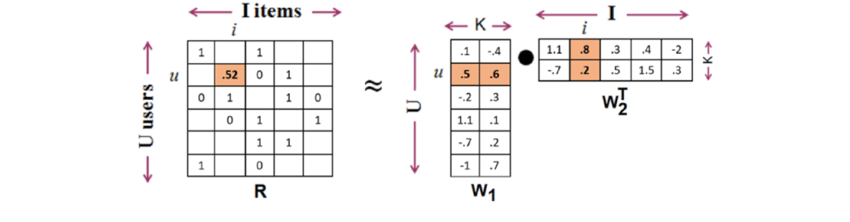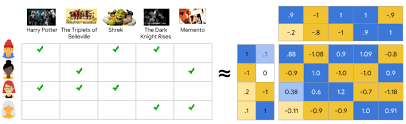

MF 모델은 2006년 Netflix에서 백만달러의 상금을 걸고 개최한 자사 추천시스템의 성능을 10% 이상 향상시키는 챌린지를 계기로 알려지게 되었습니다. 기본 아이디어는 아래 그림과 같습니다. (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 간단한 아이디어입니다. 대체로 k는 m이나 n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 훨씬 유리해집니다. 하지만 아이디어의 단순함에도 불구하고 MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델입니다.

---

첫번째 사용자의 특성(Feature) 벡터가 됩니다. 같은 방식으로 Q 행렬의 첫번째 벡터 는 아이템 특성 벡터가 되겠지요. MF 모델은 이 두 벡터를 내적해서 얻어지는 값이 정의되는 사용자의 영화 선호도로 보는 모델입니다.
* 모델 
> 모델의 목표는 모든 유저와 아이템에 대해 k-dimension의 벡터를 잘 만드는 것입니다.
벡터를 잘 만드는 기준은 유저i의 벡터와 아이템j의 벡터를 내적했을 때 유저i가 아이템j에 대해 평가한 수치와 비슷한지 입니다.

    > 사용할 모델은 밑에 URL에서 사용한 논문 모델을 사용함
http://yifanhu.net/PUB/cf.pdf

CSR
* https://lovit.github.io/nlp/machine%20learning/2018/04/09/sparse_mtarix_handling/#csr-matrix
* https://stackoverflow.com/questions/53254104/cant-understand-scipy-sparse-csr-matrix-example/62118005#62118005

In [16]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = data['user_id'].nunique()
num_artist = data['artist'].nunique()

csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape= (num_user, num_artist))
csr_data

<358869x291347 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Row format>

In [18]:
!pip install implicit

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420132 sha256=033a02c8b47818bb4f4312a3f50d4d013d8c2c31c5b5114ec278fa13d38073c4
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [19]:
import os
from implicit.als import AlternatingLeastSquares
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [20]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
# 1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 3. use_gpu : GPU를 사용할 것인지 4. iterations : epochs와 같은 의미입니다.

In [21]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<291347x358869 sparse matrix of type '<class 'numpy.longlong'>'
	with 17535578 stored elements in Compressed Sparse Column format>

In [22]:
# 모델 훈련
als_model.fit(csr_data_transpose)

In [24]:
favorite_artist = 'coldplay'
artist_id = artist_to_idx[favorite_artist]
similar_artist = als_model.similar_items(artist_id, N=15)
similar_artist

[(62, 0.12896043),
 (277, 0.12749304),
 (5, 0.12654263),
 (28, 0.12622204),
 (217, 0.12534335),
 (473, 0.1249599),
 (247, 0.12477134),
 (490, 0.12407174),
 (418, 0.12389438),
 (694, 0.1231578),
 (910, 0.12315522),
 (1018, 0.12303142),
 (268, 0.122740954),
 (782, 0.12188661),
 (75, 0.121500716)]

In [25]:
#artist_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_artist = {v:k for k,v in artist_to_idx.items()}
[idx_to_artist[i[0]] for i in similar_artist]

['coldplay',
 'muse',
 'red hot chili peppers',
 'the killers',
 'radiohead',
 'placebo',
 'the beatles',
 'oasis',
 'u2',
 'foo fighters',
 'nirvana',
 'the smashing pumpkins',
 'pink floyd',
 'the white stripes',
 'queen']

In [26]:
def get_similar_artist(artist_name: str):
    artist_id = artist_to_idx[artist_name]
    similar_artist = als_model.similar_items(artist_id)
    similar_artist = [idx_to_artist[i[0]] for i in similar_artist]
    return similar_artist

In [27]:
get_similar_artist('2pac')

['2pac',
 'dr. dre',
 'notorious b.i.g.',
 'the game',
 'nas',
 'snoop dogg',
 'jay-z',
 '50 cent',
 'ice cube',
 'ludacris']

In [28]:
get_similar_artist('lady gaga')

['lady gaga',
 'britney spears',
 'rihanna',
 'katy perry',
 'beyoncé',
 'the pussycat dolls',
 'nelly furtado',
 'christina aguilera',
 'justin timberlake',
 'kelly clarkson']

In [30]:
user = user_to_idx['asdf']
# recommend에서는 user*item CSR Matrix를 받습니다.
artist_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
artist_recommended

[(369, 0.46335667),
 (350, 0.45632923),
 (550, 0.45364177),
 (274, 0.44239885),
 (355, 0.4333571),
 (1800, 0.42327702),
 (354, 0.42194822),
 (2249, 0.40887094),
 (627, 0.398629),
 (391, 0.39633358),
 (901, 0.38785094),
 (564, 0.37165034),
 (382, 0.36892253),
 (409, 0.368702),
 (618, 0.36863834),
 (724, 0.367508),
 (5555, 0.3607438),
 (434, 0.36014432),
 (358, 0.3547847),
 (944, 0.3526716)]

In [31]:
[idx_to_artist[i[0]] for i in artist_recommended]

['justin timberlake',
 'rihanna',
 'britney spears',
 'michael jackson',
 'madonna',
 'lady gaga',
 'nelly furtado',
 'katy perry',
 'maroon 5',
 'christina aguilera',
 'pink',
 'kanye west',
 'mika',
 'amy winehouse',
 'the pussycat dolls',
 'lily allen',
 'timbaland',
 'eminem',
 'kelly clarkson',
 'avril lavigne']

In [33]:
rihanna = artist_to_idx['rihanna']
explain = als_model.explain(user, csr_data, itemid=rihanna)

In [34]:
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('beyoncé', 0.22777998754259854),
 ('black eyed peas', 0.12814492783623624),
 ('jason mraz', 0.05616679703758682),
 ('coldplay', 0.04588250489744601),
 ('maroon5', -0.00012316319740038816)]

# Movielens

In [35]:
! wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2020-08-20 06:08:48--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  4.22MB/s    in 1.3s    

2020-08-20 06:08:50 (4.22 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [41]:
import zipfile

dst = '/content/movie'
dst_file = '/content/ml-1m.zip'

if not os.path.exists(dst):
    os.makedirs(dst)


with zipfile.ZipFile(dst_file,mode='r') as file:
    file.extractall(dst)    

In [174]:
rating_file_path = '/content/movie/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
print(ratings.head())
print(orginal_data_size)

   user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
1000209


In [176]:
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [177]:
ratings.rename(columns={'rating':'star'}, inplace=True)
ratings = pd.DataFrame(ratings)
ratings.head()

,user_id,movie_id,star,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [178]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = '/content/movie/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [179]:
# 사용자들을 보기 위해 메타 데이터를 읽어옵니다.
users_file_path = '/content/movie/ml-1m/users.dat' 
cols = ['user_id','Gender','age','occupation','zip_code']
users = pd.read_csv(users_file_path, sep='::',names=cols, engine='python')
users.head()

,user_id,Gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [180]:
# 데이터셋 merge 과정
dataset = pd.merge(ratings, movies, how='left')
dataset = pd.merge(dataset, users, how='left')
dataset.head()

,user_id,movie_id,star,timestamp,title,genre,Gender,age,occupation,zip_code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [181]:
#결측치 확인 
dataset[dataset.isnull().any(axis=1)]

,user_id,movie_id,star,timestamp,title,genre,Gender,age,occupation,zip_code


In [182]:
print('ratings에 있는 유니크한 영화 개수',dataset['user_id'].nunique())
print('ratings에 있는 유니크한 사용자 수',dataset['movie_id'].nunique())

# 인기 많은 영화
favorite_movie = dataset.groupby('title')['user_id'].count()
top_30=favorite_movie.sort_values(ascending=False).head(30)
print('가장 인기있는 영화 30개',top_30)

ratings에 있는 유니크한 영화 개수 6039
ratings에 있는 유니크한 사용자 수 3628
가장 인기있는 영화 30개 title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                    

## Preprocessing

In [183]:
# 고유한 유저, 아티스트를 찾아내는 코드
user_unique = dataset['user_id'].unique()
title_unique = dataset['title'].unique()

# 유저, 아티스트 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

In [184]:
dataset.head()

,user_id,movie_id,star,timestamp,title,genre,Gender,age,occupation,zip_code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [185]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = dataset['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(dataset):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    dataset['user_id'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# title_to_idx을 통해 title 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_title_data = dataset['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(dataset):
    print('title column indexing OK!!')
    dataset['title'] = temp_title_data
else:
    print('title column indexing Fail!!')

dataset

user_id column indexing OK!!
title column indexing OK!!


,user_id,movie_id,star,timestamp,title,genre,Gender,age,occupation,zip_code
0,0,1193,5,978300760,0,Drama,F,1,10,48067
1,0,661,3,978302109,1,Animation|Children's|Musical,F,1,10,48067
2,0,914,3,978301968,2,Musical|Romance,F,1,10,48067
3,0,3408,4,978300275,3,Drama,F,1,10,48067
4,0,2355,5,978824291,4,Animation|Children's|Comedy,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...
836473,6038,1090,3,956715518,1030,Drama|War,M,25,6,11106
836474,6038,1094,5,956704887,986,Drama|Romance|War,M,25,6,11106
836475,6038,562,5,956704746,311,Comedy|Drama,M,25,6,11106
836476,6038,1096,4,956715648,142,Drama,M,25,6,11106


In [187]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

csr_dataset = dataset[['user_id','star','title']]

num_user = csr_dataset['user_id'].nunique()
num_movie = csr_dataset['title'].nunique()

csr_data = csr_matrix((csr_dataset.star, (csr_dataset.user_id, csr_dataset.title)), shape=(num_user, num_movie))
csr_data

<6039x3628 sparse matrix of type '<class 'numpy.longlong'>'
	with 836478 stored elements in Compressed Sparse Row format>

In [188]:
import os
from implicit.als import AlternatingLeastSquares
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [189]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)
# 1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 3. use_gpu : GPU를 사용할 것인지 4. iterations : epochs와 같은 의미입니다.
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6039 sparse matrix of type '<class 'numpy.longlong'>'
	with 836478 stored elements in Compressed Sparse Column format>

In [190]:
# 모델 훈련
als_model.fit(csr_data_transpose)

In [192]:
favorite_movie = 'Fargo (1996)'
movie_id = title_to_idx[favorite_movie]
similar_movie = als_model.similar_items(artist_id, N=15)
similar_movie

[(62, 0.16536102),
 (92, 0.11321801),
 (124, 0.1123961),
 (375, 0.09795973),
 (145, 0.096002765),
 (175, 0.0958359),
 (107, 0.09104499),
 (179, 0.09010607),
 (200, 0.084076986),
 (75, 0.08382361),
 (141, 0.07814191),
 (713, 0.07601207),
 (865, 0.074545786),
 (377, 0.06985092),
 (138, 0.068464205)]

In [205]:
idx_to_movie = {v:k for k,v in title_to_idx.items()}
[idx_to_movie[i[0]] for i in similar_movie]

['Total Recall (1990)',
 'Terminator 2: Judgment Day (1991)',
 'Matrix, The (1999)',
 'Face/Off (1997)',
 'Fifth Element, The (1997)',
 'Men in Black (1997)',
 'Jurassic Park (1993)',
 'Rock, The (1996)',
 'Terminator, The (1984)',
 'Hunt for Red October, The (1990)',
 'Fugitive, The (1993)',
 'Starship Troopers (1997)',
 'Predator (1987)',
 'In the Line of Fire (1993)',
 'True Lies (1994)']

In [206]:
def get_similar_movie(movie_title: str):
    movie_id = title_to_idx[movie_title]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [207]:
get_similar_movie('My Fair Lady (1964)')

['My Fair Lady (1964)',
 'West Side Story (1961)',
 'King and I, The (1956)',
 "Singin' in the Rain (1952)",
 'Oliver! (1968)',
 'American in Paris, An (1951)',
 'Gigi (1958)',
 'Sound of Music, The (1965)',
 'Romeo and Juliet (1968)',
 'South Pacific (1958)']

In [209]:
user = user_to_idx[6038]
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended
[idx_to_movie[i[0]] for i in movie_recommended]

['Close Shave, A (1995)',
 'Back to the Future (1985)',
 'M*A*S*H (1970)',
 'When Harry Met Sally... (1989)',
 'Moonstruck (1987)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Young Frankenstein (1974)',
 'Creature Comforts (1990)',
 'Blazing Saddles (1974)',
 'Shakespeare in Love (1998)',
 'Chicken Run (2000)',
 'Doctor Zhivago (1965)',
 'Bull Durham (1988)',
 'Toy Story (1995)',
 'Groundhog Day (1993)',
 "Ferris Bueller's Day Off (1986)",
 "Monty Python's Life of Brian (1979)",
 'Raising Arizona (1987)',
 'Cinema Paradiso (1988)']

In [213]:
movie_rem = title_to_idx['Close Shave, A (1995)']
explain = als_model.explain(user, csr_data, itemid=movie_rem)
[(idx_to_artist[i[0]], i[1]) for i in explain[1]]

[('säkert!', 0.36128644616142414),
 ('tegan and sara', 0.3036157987751639),
 ('kristian anttila', 0.024070363453016747),
 ('the sundays', 0.014225588789341485),
 ('jim sturgess', 0.011104536321737074),
 ('kid cudi', 0.011093498347061775),
 ('hausmarke', 0.009538576621950423),
 ('yeah yeah yeahs', 0.00524034391678608),
 ('a-ha', 0.0022556272509832004),
 ('schneider tm', 0.000886014971065224)]